In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
import clip
from torch.nn import functional as F
import torch.nn as nn
from PIL import Image
import requests
import pandas as pd
import open_clip
import os
import json
import matplotlib.pyplot as plt



# Load the configuration from the JSON file
config_path = "data_config.json"
with open(config_path, "r") as config_file:
    config = json.load(config_file)

# Access the paths from the config
data_path = config["data_path"]
features_path = config["features_path"]
img_directory_training = config["img_directory_training"]
img_directory_test = config["img_directory_test"]

In [4]:
import clip
import torch
model, preprocess = clip.load("ViT-B/32", device="cuda")

/root/anaconda3/lib/python3.8/site-packages/clip/clip.py:57: UserWarning: /root/.cache/clip/ViT-B-32.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.8MiB/s]


In [6]:
import random,torch
import numpy as np
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0) 

In [11]:
def get_rand(list1):
    
    _=torch.randperm(len(list1))
    print(list1[_])

In [13]:
list1=torch.tensor([12,3,4,5])
get_rand(list1)
get_rand(list1)
get_rand(list1)

tensor([12,  4,  5,  3])
tensor([ 5,  4, 12,  3])
tensor([ 5, 12,  4,  3])


In [2]:
def load_file_to_memory(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()
    return content

file_path = 'train.pt'
file_content = load_file_to_memory(file_path)


FileNotFoundError: [Errno 2] No such file or directory: 'train.pt'

In [ ]:
# proxy = 'http://10.16.35.10:13390'
# os.environ['http_proxy'] = proxy
# os.environ['https_proxy'] = proxy
cuda_device_count = torch.cuda.device_count()
print(cuda_device_count)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# vlmodel, preprocess = clip.load("ViT-B/32", device=device)
model_type = 'ViT-H-14'

vlmodel, preprocess_train, feature_extractor = open_clip.create_model_and_transforms(
    model_type, pretrained='laion2b_s32b_b79k', precision='fp32', device = device)


In [3]:
class EEGDataset():
    """
    subjects = ['sub-01', 'sub-02', 'sub-05', 'sub-04', 'sub-03', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
    """
    def __init__(self, data_path, exclude_subject=None, subjects=None, train=True, time_window=[0, 1.0], classes = None, pictures = None):
        self.data_path = data_path
        self.train = train
        self.subject_list = os.listdir(data_path)
        self.subjects = self.subject_list if subjects is None else subjects
        self.n_sub = len(self.subjects)
        self.time_window = time_window
        self.n_cls = 1654 if train else 200
        self.classes = classes
        self.pictures = pictures
        self.exclude_subject = exclude_subject  

        # assert any subjects in subject_list
        assert any(sub in self.subject_list for sub in self.subjects)

        self.data, self.labels, self.text, self.img = self.load_data()
        
        self.data = self.extract_eeg(self.data, time_window)
        
        
        if self.classes is None and self.pictures is None:
            # Try to load the saved features if they exist
            features_filename = os.path.join(f'{model_type}_features_train.pt') if self.train else os.path.join(f'{model_type}_features_test.pt')
            
            if os.path.exists(features_filename) :
                saved_features = torch.load(features_filename)
                self.text_features = saved_features['text_features']
                self.img_features = saved_features['img_features']
            else:
                self.text_features = self.Textencoder(self.text)
                self.img_features = self.ImageEncoder(self.img)
                torch.save({
                    'text_features': self.text_features.cpu(),
                    'img_features': self.img_features.cpu(),
                }, features_filename)
        else:
            self.text_features = self.Textencoder(self.text)
            self.img_features = self.ImageEncoder(self.img)
            
    def load_data(self):
        data_list = []
        label_list = []
        texts = []
        images = []
        
        if self.train:
            directory = img_directory_training
        else:
            directory = img_directory_test
        
        dirnames = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        dirnames.sort()
        
        if self.classes is not None:
            dirnames = [dirnames[i] for i in self.classes]

        for dir in dirnames:
            
            try:
                idx = dir.index('_')
                description = dir[idx+1:]  
            except ValueError:
                print(f"Skipped: {dir} due to no '_' found.")
                continue
                
            new_description = f"This picture is {description}"
            texts.append(new_description)

        if self.train:
            img_directory = img_directory_training  
        else:
            img_directory = img_directory_test
        
        all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
        all_folders.sort()  

        if self.classes is not None and self.pictures is not None:
            images = []  
            for i in range(len(self.classes)):
                class_idx = self.classes[i]
                pic_idx = self.pictures[i]
                if class_idx < len(all_folders):
                    folder = all_folders[class_idx]
                    folder_path = os.path.join(img_directory, folder)
                    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    all_images.sort()
                    if pic_idx < len(all_images):
                        images.append(os.path.join(folder_path, all_images[pic_idx]))
        elif self.classes is not None and self.pictures is None:
            images = []  
            for i in range(len(self.classes)):
                class_idx = self.classes[i]
                if class_idx < len(all_folders):
                    folder = all_folders[class_idx]
                    folder_path = os.path.join(img_directory, folder)
                    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    all_images.sort()
                    images.extend(os.path.join(folder_path, img) for img in all_images)
        elif self.classes is None:
            images = []  
            for folder in all_folders:
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()  
                images.extend(os.path.join(folder_path, img) for img in all_images)
        else:
            
            print("Error")
            
        print("self.subjects", self.subjects)
        print("exclude_subject", self.exclude_subject)
        for subject in self.subjects:
            if self.train:
                if subject == self.exclude_subject:  
                    continue            
                # print("subject:", subject)    
                file_name = 'preprocessed_eeg_training.npy'

                file_path = os.path.join(self.data_path, subject, file_name)
                data = np.load(file_path, allow_pickle=True)
                
                preprocessed_eeg_data = torch.from_numpy(data['preprocessed_eeg_data']).float().detach()                
                times = torch.from_numpy(data['times']).detach()[50:]
                ch_names = data['ch_names']  

                n_classes = 1654  
                samples_per_class = 10  
                
                if self.classes is not None and self.pictures is not None:
                    for c, p in zip(self.classes, self.pictures):
                        start_index = c * 1 + p
                        if start_index < len(preprocessed_eeg_data):  
                            preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+1]  
                            labels = torch.full((1,), c, dtype=torch.long).detach()  
                            data_list.append(preprocessed_eeg_data_class)
                            label_list.append(labels)  

                elif self.classes is not None and self.pictures is None:
                    for c in self.classes:
                        start_index = c * samples_per_class
                        preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+samples_per_class]
                        labels = torch.full((samples_per_class,), c, dtype=torch.long).detach()  
                        data_list.append(preprocessed_eeg_data_class)
                        label_list.append(labels)

                else:
                    for i in range(n_classes):
                        start_index = i * samples_per_class
                        # if self.exclude_subject==None:
                        #     preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+samples_per_class]
                        # else:
                        preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+samples_per_class]
                        # print("preprocessed_eeg_data_class", preprocessed_eeg_data_class.shape)
                        # preprocessed_eeg_data_class = torch.mean(preprocessed_eeg_data_class, 1)
                        # preprocessed_eeg_data_class = torch.mean(preprocessed_eeg_data_class, 0)
                        # print("preprocessed_eeg_data_class", preprocessed_eeg_data_class.shape)
                        labels = torch.full((samples_per_class,), i, dtype=torch.long).detach()  
                        data_list.append(preprocessed_eeg_data_class)
                        label_list.append(labels)

                 
            else:
                if subject == self.exclude_subject or self.exclude_subject==None:  
                    file_name = 'preprocessed_eeg_test.npy'
                    file_path = os.path.join(self.data_path, subject, file_name)
                    data = np.load(file_path, allow_pickle=True)
                    preprocessed_eeg_data = torch.from_numpy(data['preprocessed_eeg_data']).float().detach()
                    times = torch.from_numpy(data['times']).detach()[50:]
                    ch_names = data['ch_names']  
                    n_classes = 200  # Each class contains 1 images
                    
                    samples_per_class = 1  

                    for i in range(n_classes):
                        if self.classes is not None and i not in self.classes:  # If we've defined specific classes and the current class is not in the list, skip
                            continue
                        start_index = i * samples_per_class  # Update start_index for each class
                        preprocessed_eeg_data_class = preprocessed_eeg_data[start_index:start_index+samples_per_class]
                        # print("preprocessed_eeg_data_class", preprocessed_eeg_data_class.shape)
                        labels = torch.full((samples_per_class,), i, dtype=torch.long).detach()  # Add class labels
                        preprocessed_eeg_data_class = torch.mean(preprocessed_eeg_data_class.squeeze(0), 0)
                        # print("preprocessed_eeg_data_class", preprocessed_eeg_data_class.shape)
                        data_list.append(preprocessed_eeg_data_class)
                        label_list.append(labels)  # Add labels to the label list
                else:
                    continue
        # datalist: (subjects * classes) * (10 * 4 * 17 * 100)
        # data_tensor: (subjects * classes * 10 * 4) * 17 * 100
        # data_list = np.mean(data_list, )
        # print("data_list", len(data_list))
        if self.train:
            # print("data_list", *data_list[0].shape[1:])            
            data_tensor = torch.cat(data_list, dim=0).view(-1, *data_list[0].shape[2:])                 
            # data_tensor = torch.cat(data_list, dim=0).view(-1, *data_list[0].shape[1:])
            # data_tensor = torch.cat(data_list, dim=0).view(-1, *data_list[0].shape)   
            # print("label_tensor", label_tensor.shape)
            print("data_tensor", data_tensor.shape)
        else:           
            data_tensor = torch.cat(data_list, dim=0).view(-1, *data_list[0].shape)   
            # label_tensor = torch.cat(label_list, dim=0)
            # print("label_tensor", label_tensor.shape)
            # data_tensor = torch.cat(data_list, dim=0).view(-1, *data_list[0].shape[2:])
        # print("data_tensor", data_tensor.shape)
        # label_list: (subjects * classes) * 10
        # label_tensor: (subjects * classes * 10)
        # print("label_tensor = torch.cat(label_list, dim=0)")
        # print(label_list)
        label_tensor = torch.cat(label_list, dim=0)
        # label_tensor = torch.cat(label_list, dim=0)
        # print(label_tensor[:300])
        if self.train:
            # label_tensor: (subjects * classes * 10 * 4)
            label_tensor = label_tensor.repeat_interleave(4)
            if self.classes is not None:
                unique_values = list(label_tensor.numpy())
                lis = []
                for i in unique_values:
                    if i not in lis:
                        lis.append(i)
                unique_values = torch.tensor(lis)        
                mapping = {val.item(): index for index, val in enumerate(unique_values)}   
                label_tensor = torch.tensor([mapping[val.item()] for val in label_tensor], dtype=torch.long)

        else:
            # label_tensor = label_tensor.repeat_interleave(80)
            # if self.classes is not None:
            #     unique_values = torch.unique(label_tensor, sorted=False)
           
            #     mapping = {val.item(): index for index, val in enumerate(torch.flip(unique_values, [0]))}
            #     label_tensor = torch.tensor([mapping[val.item()] for val in label_tensor], dtype=torch.long)
            pass      

                    
        self.times = times
        self.ch_names = ch_names

        print(f"Data tensor shape: {data_tensor.shape}, label tensor shape: {label_tensor.shape}, text length: {len(texts)}, image length: {len(images)}")
        
        return data_tensor, label_tensor, texts, images

    def extract_eeg(self, eeg_data, time_window):

        start, end = time_window

        # Get the indices of the times within the specified window
        indices = (self.times >= start) & (self.times <= end)
        # print("self.times", self.times.shape)
        # print("indices", indices)
        # print("indices", indices.shape)
        # print("eeg_data", eeg_data.shape)
        # Use these indices to select the corresponding data
        extracted_data = eeg_data[..., indices]
        # print(f"extracted_data shape: {extracted_data.shape}")

        return extracted_data
    
    def Textencoder(self, text):   
            
            text_inputs = torch.cat([clip.tokenize(t) for t in text]).to(device)
            
            with torch.no_grad():
                text_features = vlmodel.encode_text(text_inputs)
            
            text_features = F.normalize(text_features, dim=-1).detach()
       
            return text_features
        
    def ImageEncoder(self,images):
        batch_size = 20  
        image_features_list = []
      
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            image_inputs = torch.stack([preprocess_train(Image.open(img).convert("RGB")) for img in batch_images]).to(device)

            with torch.no_grad():
                batch_image_features = vlmodel.encode_image(image_inputs)
                batch_image_features /= batch_image_features.norm(dim=-1, keepdim=True)

            image_features_list.append(batch_image_features)

        image_features = torch.cat(image_features_list, dim=0)
        
        return image_features
    
    def __getitem__(self, index):
        # Get the data and label corresponding to "index"
        # index: (subjects * classes * 10 * 4)
        x = self.data[index]
        label = self.labels[index]
        
        if self.pictures is None:
            if self.classes is None:
                index_n_sub_train = self.n_cls * 10 * 4
                index_n_sub_test = self.n_cls * 1 * 80
            else:
                index_n_sub_test = len(self.classes)* 1 * 80
                index_n_sub_train = len(self.classes)* 10 * 4
            # text_index: classes
            if self.train:
                text_index = (index % index_n_sub_train) // (10 * 4)
            else:
                text_index = (index % index_n_sub_test) // (1 * 80)
            # img_index: classes * 10
            if self.train:
                img_index = (index % index_n_sub_train) // (4)
            else:
                img_index = (index % index_n_sub_test) // (80)
        else:
            if self.classes is None:
                index_n_sub_train = self.n_cls * 1 * 4
                index_n_sub_test = self.n_cls * 1 * 80
            else:
                index_n_sub_test = len(self.classes)* 1 * 80
                index_n_sub_train = len(self.classes)* 1 * 4
            # text_index: classes
            if self.train:
                text_index = (index % index_n_sub_train) // (1 * 4)
            else:
                text_index = (index % index_n_sub_test) // (1 * 80)
            # img_index: classes * 10
            if self.train:
                img_index = (index % index_n_sub_train) // (4)
            else:
                img_index = (index % index_n_sub_test) // (80)
                
        text = self.text[text_index]
        img = self.img[img_index]
        
        text_features = self.text_features[text_index]
        img_features = self.img_features[img_index]
        
        return x, label, text, text_features, img, img_features

    def __len__(self):
        return self.data.shape[0]  # or self.labels.shape[0] which should be the same


self.subjects ['sub-01']
exclude_subject None
data_tensor torch.Size([66160, 63, 250])
Data tensor shape: torch.Size([66160, 63, 250]), label tensor shape: torch.Size([66160]), text length: 1654, image length: 16540
self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
Index 79, Label: 79, text: This picture is aircraft_carrier


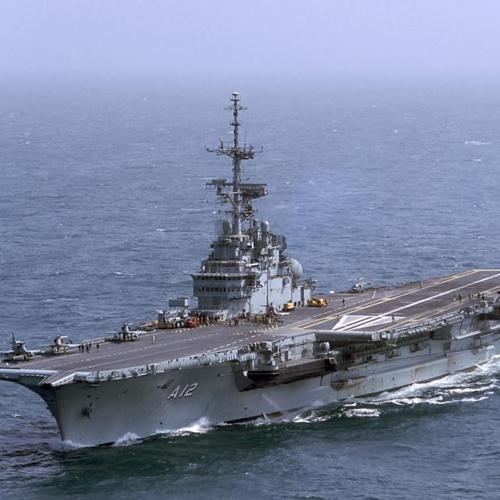

In [4]:
data_path = data_path
train_dataset = EEGDataset(data_path, subjects = ['sub-01'], train=True)    
test_dataset = EEGDataset(data_path, subjects = ['sub-01'], train=False)
# train_dataset = EEGDataset(data_path, exclude_subject = 'sub-01', train=True)    
# test_dataset = EEGDataset(data_path, exclude_subject = 'sub-01', train=False)    
# train_dataset = EEGDataset(data_path, train=True) 
# test_dataset = EEGDataset(data_path, train=False) 

# 100 Hz
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

i = 80*1-1
x, label, text, text_features, img, img_features  = test_dataset[i]
print(f"Index {i}, Label: {label}, text: {text}")
Image.open(img)
            

In [7]:
x, label, text, text_features, img, img_features = train_dataset[0]

In [19]:
img_features.shape

torch.Size([1024])

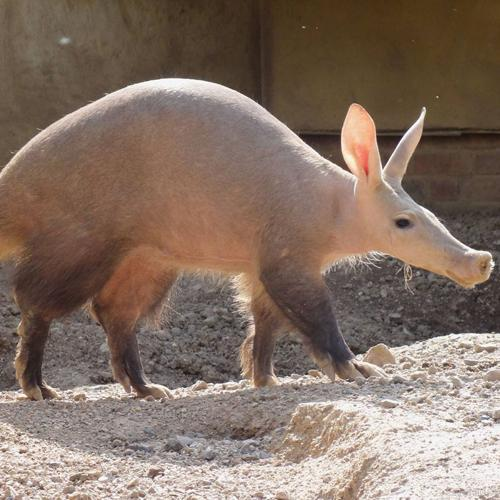

In [8]:
Image.open(img)

In [6]:
texts=[]
train=True
if train:
    directory = img_directory_training
else:
    directory = img_directory_test

dirnames = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
dirnames.sort()
for dir in dirnames:
    
    try:
        idx = dir.index('_')
        description = dir[idx+1:]  
    except ValueError:
        print(f"Skipped: {dir} due to no '_' found.")
        continue
    print(description)
    texts.append(description)


aardvark
abacus
accordion
acorn
air_conditioner
air_mattress
air_pump
airbag
airboat
airplane
album
alligator
almond
aloe
alpaca
altar
aluminum_foil
amber
ambulance
amplifier
anchor
ankle
anklet
ant
anteater
antenna
anvil
appetizer
apple
apple_tree
applesauce
apron
aquarium
arch
arm
armor
arrow
artichoke
arugula
ashtray
asparagus
avocado
awning
axe
baby
backdrop
backgammon
backpack
bacon
badge
badger
bag
bagel
bagpipe
baklava
ball
balloon
ballot_box
bamboo
banana_peel
banana_split
bandage
bandanna
banjo
bank
banner
barbed_wire
barbell
barcode
bark
barnacle
barrel
barrette
baseball
baseball_glove
basket
basketball_hoop
bassinet
bat1
bat2
bathmat
bathrobe
bathtub
baton1
baton2
baton3
battery
bazooka
beachball
bead
beaker
bean
beanbag
beanie
bear
beard
bed
bedpan
bedpost
bee
beehive
beer
beet
beetle
bell
bell_pepper
belt
belt_buckle
berry
bib
bikini
bin
binder
binoculars
bird
birdbath
birdcage
birdhouse
biscuit
bison
blackberry
blanket
blazer
blender
blimp
blind
blinder
blindfold
block
bl

In [57]:
df = pd.read_csv('/root/workspace/wht/multimodal_brain/datasets/things_concepts.tsv', sep='\t')

# row_sums = df.sum(axis=1)
# row_sums.max()
col_list = ['uniqueID','Bottom-up Category (Human Raters)','Top-down Category (WordNet)','Top-down Category (manual selection)','All Bottom-up Categories']

for i in range(len(col_list)):

    class_list = df[col_list[i]].unique()
    nan_count = df[col_list[i]].notna().sum()
    print(len(class_list),nan_count)
    # print(col_list)

1854 1854
46 926
30 960
69 1295
942 1854


In [72]:
path = '/root/workspace/wht/multimodal_brain/datasets/things-eeg-small/Image_set/image_metadata.npy'
data = np.load(path, allow_pickle=True)
data

array({'test_img_concepts': ['00001_aircraft_carrier', '00002_antelope', '00003_backscratcher', '00004_balance_beam', '00005_banana', '00006_baseball_bat', '00007_basil', '00008_basketball', '00009_bassoon', '00010_baton4', '00011_batter', '00012_beaver', '00013_bench', '00014_bike', '00015_birthday_cake', '00016_blowtorch', '00017_boat', '00018_bok_choy', '00019_bonnet', '00020_bottle_opener', '00021_brace', '00022_bread', '00023_breadbox', '00024_bug', '00025_buggy', '00026_bullet', '00027_bun', '00028_bush', '00029_calamari', '00030_candlestick', '00031_cart', '00032_cashew', '00033_cat', '00034_caterpillar', '00035_cd_player', '00036_chain', '00037_chaps', '00038_cheese', '00039_cheetah', '00040_chest2', '00041_chime', '00042_chopsticks', '00043_cleat', '00044_cleaver', '00045_coat', '00046_cobra', '00047_coconut', '00048_coffee_bean', '00049_coffeemaker', '00050_cookie', '00051_cordon_bleu', '00052_coverall', '00053_crab', '00054_creme_brulee', '00055_crepe', '00056_crib', '00057_

In [73]:
df = pd.read_csv('/root/workspace/wht/multimodal_brain/datasets/things/THINGS/27 higher-level categories/category_mat_manual.tsv', sep='\t')
row_sums = df.sum(axis=1)
filtered_rows = df[row_sums ==0]
filtered_rows

,animal,bird,body part,clothing,clothing accessory,container,dessert,drink,electronic device,food,...,musical instrument,office supply,part of car,plant,sports equipment,tool,toy,vegetable,vehicle,weapon
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
class_list = df['Top-down Category (WordNet)'].unique()
print(len(class_list))
print(class_list)


nan_count = df['Top-down Category (WordNet)'].notna().sum()
print("class_list 中NaN 的数量:", nan_count)



_ = list(df[df['Top-down Category (WordNet)']=='vehicle']['Word'])
print(', '.join(_))

_ = list(df[df['Top-down Category (WordNet)']=='container, vehicle']['Word'])
print(', '.join(_))

_ = list(df[df['Top-down Category (WordNet)']=='vehicle, weapon']['Word'])
print(', '.join(_))

30
['animal' nan 'musical instrument' 'fruit' 'container' 'vehicle' 'plant'
 'container, vehicle' 'body part' 'decoration' 'animal, insect' 'food'
 'clothing' 'weapon' 'vegetable' 'tool' 'sports equipment' 'toy'
 'food, dessert' 'furniture' 'food, beverage' 'kitchen utensil'
 'animal, bird' 'container, kitchen utensil' 'kitchen appliance'
 'electronic device' 'food, vegetable'
 'container, sports equipment, vehicle' 'sports equipment, weapon'
 'vehicle, weapon']
class_list 中NaN 的数量: 960
aircraft carrier, airplane, blimp, boat, bobsled, canoe, cruise ship, ferry, gondola, helicopter, hot-air balloon, hovercraft, humvee, jet, kayak, sailboat, seaplane, ship, sled, space shuttle, speedboat, steamroller, submarine, tugboat, wreck, yacht
ambulance, bike, bulldozer, camper, car, carriage, cart, chariot, dirt bike, firetruck, forklift, garbage truck, go-kart, hearse, jeep, limousine, minivan, motorcycle, police car, rickshaw, scooter, shopping cart, skateboard, snowmobile, snowplow, station w

In [54]:
df[df['Top-down Category (WordNet)'].isna()]

,Word,uniqueID,Example image,Bigram,Percent_known,Rank (combining COCA/concreteness),Concreteness (M),COCA word freq (online),COCA word freq,COCA (dispersion),...,Top-down Category (WordNet),Top-down Category (manual selection),All Bottom-up Categories,WordNet Synonyms,WordNet ID,Wordnet ID2,Wordnet ID3,Wordnet ID4,"Definition (from WordNet, Google, or Wikipedia)",Number of word meanings in list
1,abacus,abacus,https://imgur.com/peZeM0l,0,0.93,17741.0,4.52,188,97.0,0.86,...,NaN,home decor,mathematical device,abacus,n02666196,abacus%1:06:00::,abacus#2,abacus.n.02,a calculator that performs arithmetic function...,1
4,air conditioner,air_conditioner,https://imgur.com/KqYNwWH,1,1.00,12115.0,4.93,943,NaN,NaN,...,NaN,electronic device,home appliance,"air_conditioner, air_conditioning",n02686379,air_conditioner%1:06:00::,air_conditioner#1,air_conditioner.n.01,a system that keeps air cool and dry,1
5,air mattress,air_mattress,https://imgur.com/HjodlKf,1,1.00,15398.0,4.71,127,NaN,NaN,...,NaN,furniture,bedding,air_mattress,n02690809,air_mattress%1:06:00::,air_mattress#1,air_mattress.n.01,a mattress that can be stored flat and inflate...,1
6,air pump,air_pump,https://imgur.com/AevyIeO,1,0.96,15302.5,4.81,82,NaN,NaN,...,NaN,tool,bicycle equipment,"air_pump, vacuum_pump",n02692513,air_pump%1:06:00::,air_pump#1,air_pump.n.01,a pump that moves air in or out of something,1
8,airboat,airboat,https://imgur.com/LKuZYNu,0,0.93,14495.5,4.82,112,118.0,0.74,...,NaN,vehicle,watercraft,airboat,NaN,NaN,NaN,NaN,a shallow-draft boat powered by an aircraft en...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,wooden leg,wooden_leg,https://imgur.com/HKwIpct,1,1.00,13717.5,4.93,94,NaN,NaN,...,NaN,NaN,prosthetics,"peg, wooden_leg, leg, pegleg",n03906106,wooden_leg%1:06:00::,wooden_leg#1,wooden_leg.n.01,a prosthesis that replaces a missing leg,1
1838,wrapping paper,wrapping_paper,https://imgur.com/t1HIIUl,1,1.00,11961.5,4.71,406,NaN,NaN,...,NaN,NaN,gift accessory,wrapping_paper,n15105122,wrapping_paper%1:27:00::,wrapping_paper#1,wrapping_paper.n.01,a tough paper used for wrapping,1
1846,yarn,yarn,https://imgur.com/SZlfzso,0,0.97,6412.5,4.93,1318,1177.0,0.91,...,NaN,NaN,craft supply,yarn,NaN,NaN,NaN,NaN,"spun thread used for knitting, weaving, or sewing",1
1849,yoke,yoke,https://imgur.com/nOt3K3f,0,0.97,9558.5,4.83,692,597.0,0.90,...,NaN,NaN,"farm equipment, animal harness",yoke,n04612840,yoke%1:06:00::,yoke#7,yoke.n.07,stable gear that joins two draft animals at th...,1


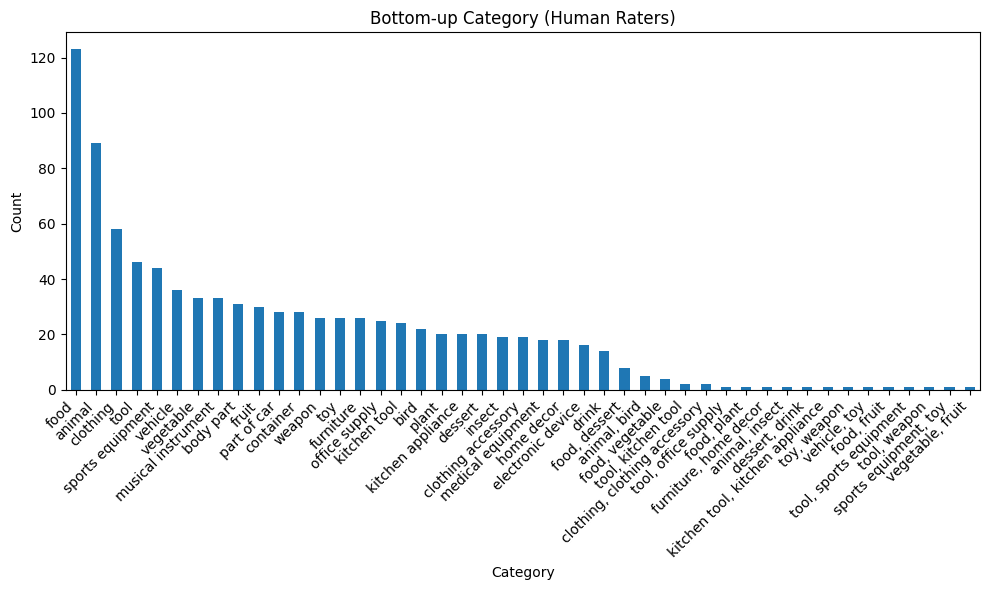

In [52]:
category_counts = df['Bottom-up Category (Human Raters)'].value_counts()
# 绘制柱状图
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bottom-up Category (Human Raters)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好地显示
plt.tight_layout()
plt.show()

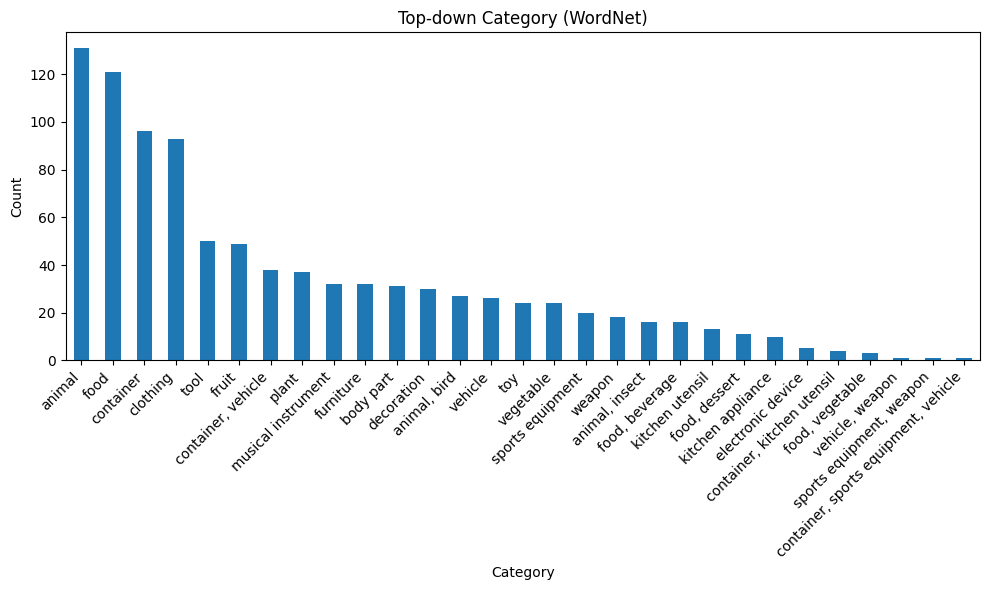

In [51]:
category_counts = df['Top-down Category (WordNet)'].value_counts()
# 绘制柱状图
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Top-down Category (WordNet)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好地显示
plt.tight_layout()
plt.show()

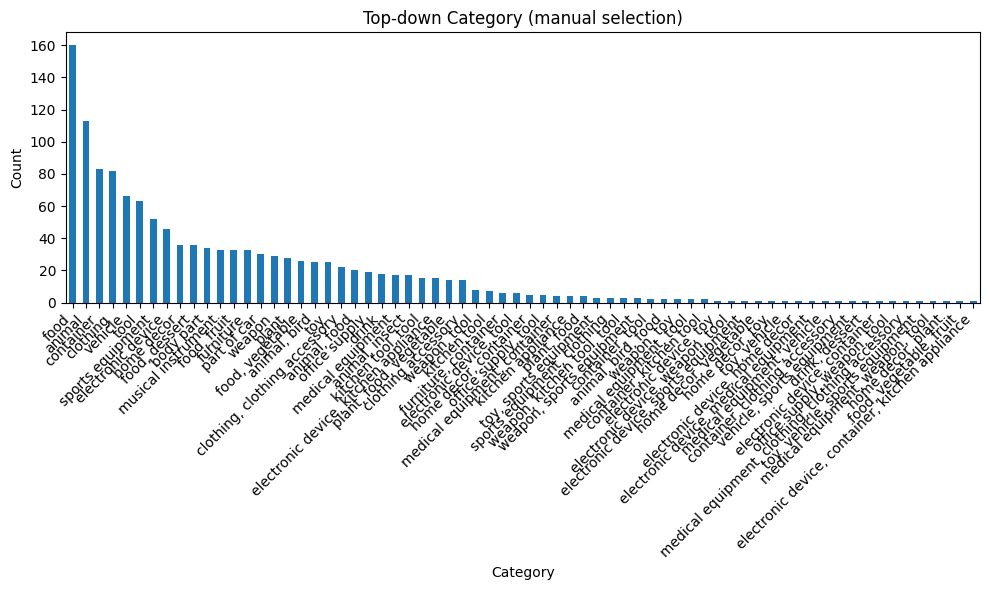

In [50]:
category_counts = df['Top-down Category (manual selection)'].value_counts()
# 绘制柱状图
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Top-down Category (manual selection)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好地显示
plt.tight_layout()
plt.show()



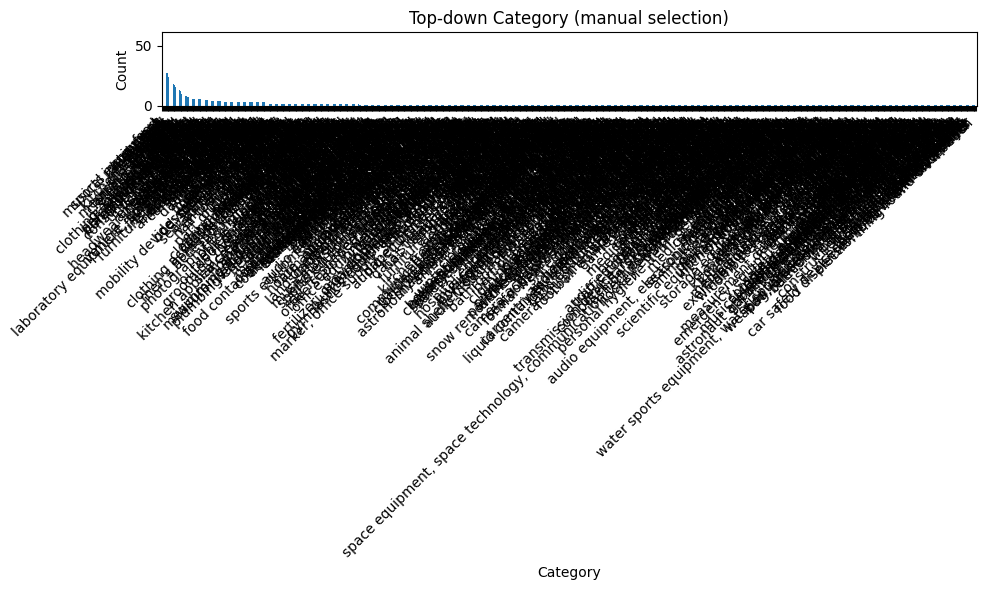

In [53]:
category_counts = df['All Bottom-up Categories'].value_counts()
# 绘制柱状图
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Top-down Category (manual selection)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好地显示
plt.tight_layout()
plt.show()


In [23]:
df.head()

,Word,uniqueID,Example image,Bigram,Percent_known,Rank (combining COCA/concreteness),Concreteness (M),COCA word freq (online),COCA word freq,COCA (dispersion),...,Top-down Category (WordNet),Top-down Category (manual selection),All Bottom-up Categories,WordNet Synonyms,WordNet ID,Wordnet ID2,Wordnet ID3,Wordnet ID4,"Definition (from WordNet, Google, or Wikipedia)",Number of word meanings in list
0,aardvark,aardvark,https://imgur.com/LAJGlN0,0,1.00,18158.5,4.68,53,28.0,0.78,...,animal,animal,animal,"aardvark, ant_bear, anteater, Orycteropus_afer",n02082791,aardvark%1:05:00::,aardvark#1,aardvark.n.01,nocturnal burrowing mammal of the grasslands o...,1
1,abacus,abacus,https://imgur.com/peZeM0l,0,0.93,17741.0,4.52,188,97.0,0.86,...,NaN,home decor,mathematical device,abacus,n02666196,abacus%1:06:00::,abacus#2,abacus.n.02,a calculator that performs arithmetic function...,1
2,accordion,accordion,https://imgur.com/GgGvdZR,0,0.97,8541.0,4.86,816,735.0,0.90,...,musical instrument,musical instrument,musical instrument,"accordion, piano_accordion, squeeze_box",n02672831,accordion%1:06:00::,accordion#1,accordion.n.01,a portable box-shaped free-reed instrument; th...,1
3,acorn,acorn,https://imgur.com/YfIB5lM,0,1.00,7723.5,4.96,1289,692.0,0.85,...,fruit,NaN,nut,acorn,n12267677,acorn%1:20:00::,acorn#1,acorn.n.01,fruit of the oak tree: a smooth thin-walled nu...,1
4,air conditioner,air_conditioner,https://imgur.com/KqYNwWH,1,1.00,12115.0,4.93,943,NaN,NaN,...,NaN,electronic device,home appliance,"air_conditioner, air_conditioning",n02686379,air_conditioner%1:06:00::,air_conditioner#1,air_conditioner.n.01,a system that keeps air cool and dry,1


In [17]:
count = (row_sums > 1).sum()
count

302

In [ ]:
super_super_class_1 = ['food', 'fruit', 'vegetable', 'dessert', 'drink','plant'] #6
super_super_class_2 = ['animal', 'bird', 'insect'] #3
super_super_class_3 = ['clothing', 'clothing accessory', 'home decor', 'kitchen appliance', 'kitchen tool', 'office supply', 'toy'] #7
super_super_class_4 = ['part of car', 'vehicle', 'sports equipment']  #3
except_class = ['body part', 'musical instrument'] #3
other_class = ['']